In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
data = pd.read_csv('/content/spam.csv', encoding='latin1')

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
data.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [ ]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.rename(columns = {'v1' : 'output', 'v2' : 'input'}, inplace = True)

In [ ]:
data.columns

Index(['output', 'input'], dtype='object')

In [ ]:
data['output'].value_counts()

,count
output,
ham,4825
spam,747


In [ ]:
#Data preprocessing

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
ps = PorterStemmer()
corpus = []

for i in range(0, len(data)):
  text = re.sub('[^a-zA-Z]', ' ', data['input'][i])
  text = text.lower()
  text = text.split()
  text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
  text = ' '.join(text)
  corpus.append(text)

In [ ]:
corpus[10]

'gonna home soon want talk stuff anymor tonight k cri enough today'

In [ ]:
vectorizer = TfidfVectorizer()
ip_vector = vectorizer.fit_transform(corpus)

In [ ]:
ip_vector[0]

<1x6221 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [ ]:
input = ip_vector.toarray()

In [ ]:
input

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
output = encoder.fit_transform(data['output'])
output

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
models = {
    'MultinomialNB' : (MultinomialNB(), {'alpha' :[0.1, 0.5, 1.0, 2.0]}),
    'RandomForest' : (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]}),
    'SVC' : (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']})
}

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_estimators = {}

for model_name, (model, params) in models.items():

    grid_search = GridSearchCV(model, params, cv=stratified_kfold, n_jobs=-1, scoring='accuracy')

    grid_search.fit(x_train, y_train)

    best_estimators[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

for model_name, results in best_estimators.items():
    print(f"{model_name}:")
    print(f"  Best Score: {results['best_score']:.4f}")
    print(f"  Best Params: {results['best_params']}")


MultinomialNB:
  Best Score: 0.9814
  Best Params: {'alpha': 0.1}
RandomForest:
  Best Score: 0.9785
  Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
SVC:
  Best Score: 0.9812
  Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


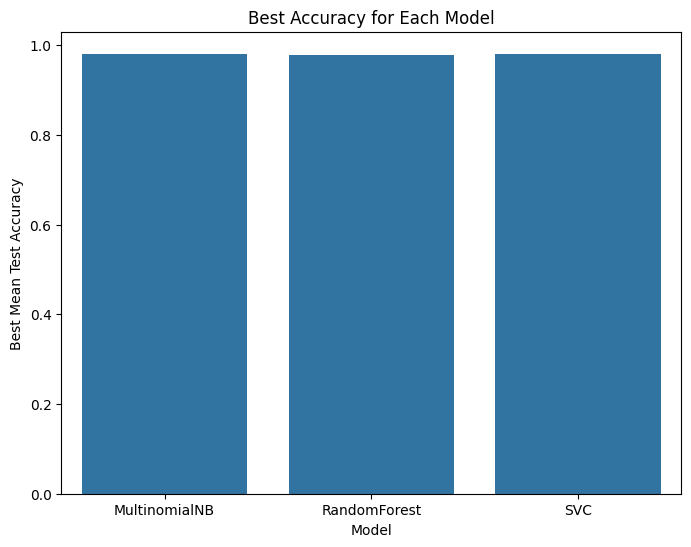

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

model_names = list(best_estimators.keys())
best_scores = [best_estimators[model]['best_score'] for model in model_names]

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=best_scores)
plt.title("Best Accuracy for Each Model")
plt.xlabel("Model")
plt.ylabel("Best Mean Test Accuracy")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

for model_name, results in best_estimators.items():
    model = results['best_estimator']
    y_pred = model.predict(x_test)

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))


MultinomialNB Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.93      0.91      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.85      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98     

In [ ]:
best_nb_model = grid_search.best_estimator_
best_nb_model

SVC(C=1, kernel='linear')

In [ ]:
new_data = ["Here are your monthly highlights"]

new_data = vectorizer.transform(new_data)

In [ ]:
best_nb_model.predict(new_data.toarray())

array([0])

In [ ]:
# Neural network

In [ ]:
pip install keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
token = Tokenizer()

token.fit_on_texts(corpus)

sequences = token.texts_to_sequences(corpus)

In [ ]:
# Padding sequences to ensure uniform length
sentence_length = 100
pad_rep = pad_sequences(sequences, padding = 'post', maxlen = sentence_length)

In [ ]:
word_index = token.word_index

# Calculate the vocabulary size
vocab_size = len(word_index)
vocab_size

6239

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(pad_rep, output, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 70, input_length = sentence_length))
model.add(SimpleRNN(70, activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.build(input_shape=(None, sentence_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 70)             │         436,730 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 70)                  │           9,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              71 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 446,671 (1.70 MB)

 Trainable params: 446,671 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor= 'val_loss', patience= 10, restore_best_weights= True)

In [ ]:
model.fit(x_train, y_train, validation_split= 0.2, batch_size = 10, epochs = 50, callbacks = [early_stop] )

Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8478 - loss: 0.4371 - val_accuracy: 0.8621 - val_loss: 0.4155
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8680 - loss: 0.3984 - val_accuracy: 0.8621 - val_loss: 0.4013
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8664 - loss: 0.3955 - val_accuracy: 0.8621 - val_loss: 0.4018
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8703 - loss: 0.3882 - val_accuracy: 0.8621 - val_loss: 0.4011
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8561 - loss: 0.4129 - val_accuracy: 0.8621 - val_loss: 0.4020
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8534 - loss: 0.4168 - val_accuracy: 0.8621 - val_loss: 0.4021
Epoch 7/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8632 - loss: 0.4008 - val_accuracy: 0.8621 - val_loss: 0.4064
Epoch 8/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8632 - loss: 0.4014 - val_acc